In [1]:
import os
import json
import itertools
import pprint
from dataset import MinecraftAutoregKStepsTokensDataset
from transformers import AutoTokenizer

/home/akhare/anaconda3/envs/tfl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

In [3]:
minecraft_dataset = MinecraftAutoregKStepsTokensDataset(num_steps=0, dataset_len=32000, tokenizer=tokenizer)
print("Length of dataset: ", len(minecraft_dataset))

Found  622  rules.
Length of dataset:  24383


In [19]:
minecraft_dataset = MinecraftAutoregKStepsTokensDataset(num_steps=3, dataset_len=20000, tokenizer=tokenizer)
print("Length of dataset: ", len(minecraft_dataset))

Length of dataset:  20000


In [20]:
print("First 5 elements of the dataset: ")

for i in range(50):
    item = minecraft_dataset[i]
    for key in item:
        print(key.upper())
        print(item[key])
    print("\n\n\n")

First 5 elements of the dataset: 
DATA
[RULES_START] pink_tulip -> pink_dye , yellow_dye + white_bed -> yellow_bed , purple_dye + pink_dye -> magenta_dye , blue_dye + red_dye -> purple_dye , glass + magenta_dye -> magenta_stained_glass [RULES_END] [FACTS_START] blue_dye , glass , white_bed , pink_tulip , yellow_dye , red_dye [FACTS_END] [TARGET_START] magenta_stained_glass [TARGET_END]
LABELS
tensor(1)
INPUT_IDS
[58, 49, 6239, 1546, 62, 2257, 7227, 60, 11398, 62, 83, 377, 541, 4613, 11398, 62, 67, 5948, 837, 7872, 62, 67, 5948, 1343, 2330, 62, 3077, 4613, 7872, 62, 3077, 837, 14032, 62, 67, 5948, 1343, 11398, 62, 67, 5948, 4613, 2153, 29188, 62, 67, 5948, 837, 4171, 62, 67, 5948, 1343, 2266, 62, 67, 5948, 4613, 14032, 62, 67, 5948, 837, 5405, 1343, 2153, 29188, 62, 67, 5948, 4613, 2153, 29188, 62, 44279, 62, 20721, 685, 49, 6239, 1546, 62, 10619, 60, 685, 37, 2246, 4694, 62, 2257, 7227, 60, 4171, 62, 67, 5948, 837, 5405, 837, 2330, 62, 3077, 837, 11398, 62, 83, 377, 541, 837, 7872, 62,

In [5]:
minecraft_dataset = MinecraftAutoregKStepsTokensDataset(num_steps=1, dataset_len=32000)
print("Length of dataset: ", len(minecraft_dataset))

Length of dataset:  32000


In [6]:
print(minecraft_dataset[0])

[({'minecraft:polished_blackstone'}, 'minecraft:polished_blackstone_bricks', 0), ({'minecraft:blackstone'}, 'minecraft:polished_blackstone', 1)]


In [11]:
def get_string_rep(recipe: list):
    # Shuffle the rules of the recipe
    shuffled_recipe = list(itertools.permutations(recipe))
    # Convert the recipe to a string
    # If the depth of a rule is 0, collect its antecedents as facts
    facts = []
    target = None
    max_depth = max([rule[2] for rule in recipe])
    rules_str = "[RULES_START] "
    for rule in recipe:
        if rule[2] == max_depth:
            facts.extend(rule[0])
        if rule[2] == 0:
            target = rule[1]
        rules_str += f"{' + '.join(rule[0])} -> {rule[1]} , "
    rules_str = rules_str[:-2]
    rules_str += "[RULES_END]"
    facts_str = "[FACTS_START] " + " , ".join(facts) + " [FACTS_END]"
    target_str = f"[TARGET_START] {target} [TARGET_END]"
    return f"{rules_str} {facts_str} {target_str}"

In [12]:
print(get_string_rep(minecraft_dataset[3]))

[RULES_START] minecraft:paper + minecraft:compass -> minecraft:map , minecraft:redstone + minecraft:iron_ingot -> minecraft:compass [RULES_END] [FACTS_START] minecraft:redstone , minecraft:iron_ingot [FACTS_END] [TARGET_START] minecraft:map [TARGET_END]


In [6]:
dataset_dir = r"/home/akhare/repos/Minecraft-Crafting-Web/minecraft-data/recipes"

recipe_files = os.listdir(dataset_dir)
recipe_files = [os.path.join(dataset_dir, f) for f in recipe_files if f.endswith(".json")]
recipes = {f: json.load(open(f)) for f in recipe_files}


In [7]:
# # print one recipe for each unique type
# types = set([r["type"] for r in recipes.values()])

# for t in types:
#     print(t)
#     for r in recipes.values():
#         if r["type"] == t:
#             print(r)
#             break
#     print("\n")

In [8]:
# TODO: add support for exceptions

rules = []

for recipe_file, recipe in recipes.items():
    try:
        recipe_type = recipe["type"]

        if "crafting" not in recipe_type:
            continue
        antecedents = set()
        consequents = set()
        antecedents_group_key = "key" if "key" in recipe else "ingredients" if "ingredients" in recipe else "ingredient" if ("ingredient" in recipe and len(recipe["ingredient"]) > 1) else None
        if antecedents_group_key is not None:
            for ingredient in (recipe[antecedents_group_key].values() if antecedents_group_key == "key" else recipe[antecedents_group_key]):
                antecedents.add(ingredient["item"] if "item" in ingredient else ingredient["tag"])
        else:
            if "ingredient" in recipe:
                antecedents.add(recipe["ingredient"]["item"] if "item" in recipe["ingredient"] else recipe["ingredient"]["tag"])
            if "base" in recipe:
                antecedents.add(recipe["base"]["item"] if "item" in recipe["base"] else recipe["base"]["tag"])
            if "addition" in recipe:
                antecedents.add(recipe["addition"]["item"] if "item" in recipe["addition"] else recipe["addition"]["tag"])
        if "result" in recipe:
            consequents.add(recipe["result"]["item"] if "item" in recipe["result"] else recipe["result"])
        if len(consequents) > 0:
            rules.append((antecedents, consequents, recipe_type, recipe))
    except:
        print(recipe_file)
        print(recipe)

/home/akhare/repos/Minecraft-Crafting-Web/minecraft-data/recipes/tnt.json
{'type': 'minecraft:crafting_shaped', 'pattern': ['X#X', '#X#', 'X#X'], 'key': {'#': [{'item': 'minecraft:sand'}, {'item': 'minecraft:red_sand'}], 'X': {'item': 'minecraft:gunpowder'}}, 'result': {'item': 'minecraft:tnt'}}
/home/akhare/repos/Minecraft-Crafting-Web/minecraft-data/recipes/red_sandstone_slab.json
{'type': 'minecraft:crafting_shaped', 'pattern': ['###'], 'key': {'#': [{'item': 'minecraft:red_sandstone'}, {'item': 'minecraft:chiseled_red_sandstone'}]}, 'result': {'item': 'minecraft:red_sandstone_slab', 'count': 6}}
/home/akhare/repos/Minecraft-Crafting-Web/minecraft-data/recipes/fire_charge.json
{'type': 'minecraft:crafting_shapeless', 'ingredients': [{'item': 'minecraft:gunpowder'}, {'item': 'minecraft:blaze_powder'}, [{'item': 'minecraft:coal'}, {'item': 'minecraft:charcoal'}]], 'result': {'item': 'minecraft:fire_charge', 'count': 3}}
/home/akhare/repos/Minecraft-Crafting-Web/minecraft-data/recipes/

In [9]:
# Get all the histories for a given item
# Each history is a list of rules that can be used to craft the item
# Every branch in the history is a different way to craft the item and hence a different history

def get_all_ways_to_craft(item, rules, items_so_far=None, depth=0):
    histories = []
    for antecedents, consequents, _, _ in rules:
        if item in consequents:
            history = [(antecedents, item, depth)]
            if items_so_far is None:
                items_so_far = [item]
            else:
                items_so_far.append(item)
            antecedent_histories = []
            for antecedent in antecedents:
                if antecedent in items_so_far:
                    continue
                all_ways_to_craft_antecedent = get_all_ways_to_craft(antecedent, rules, items_so_far, depth + 1)
                if len(all_ways_to_craft_antecedent) > 0:
                    antecedent_histories.append(all_ways_to_craft_antecedent)
            histories.append(history)
            
            for antecendent_way_combination in itertools.product(*antecedent_histories):
                for chain_len in range(1, len(antecendent_way_combination) + 1):
                    for antecedent_history_combination in itertools.combinations(antecendent_way_combination, chain_len):
                        history_combination = history.copy()
                        # Extend by flattening the list
                        for antecedent_history in antecedent_history_combination:
                            history_combination.extend(antecedent_history)
                        histories.append(history_combination)
    return histories

In [10]:
magenta_banner_histories = get_all_ways_to_craft("minecraft:magenta_banner", rules)

In [11]:
# Remove all redundant histories

def remove_redundant_histories(histories):
    unique_histories = []
    for history in histories:
        if history not in unique_histories:
            unique_histories.append(history)
    return unique_histories

unique_magenta_banner_histories = remove_redundant_histories(magenta_banner_histories)

In [12]:
print(len(magenta_banner_histories))
print(len(unique_magenta_banner_histories))

21265
1437


In [13]:
for i, history in enumerate(unique_magenta_banner_histories):
    print("History", i)
    for rule in history:
        print(f"Rule: {rule[0]} -> {rule[1]} (depth: {rule[2]})")
    print("\n")

History 0
Rule: {'minecraft:stick', 'minecraft:magenta_wool'} -> minecraft:magenta_banner (depth: 0)


History 1
Rule: {'minecraft:stick', 'minecraft:magenta_wool'} -> minecraft:magenta_banner (depth: 0)
Rule: {'minecraft:bamboo'} -> minecraft:stick (depth: 1)


History 2
Rule: {'minecraft:stick', 'minecraft:magenta_wool'} -> minecraft:magenta_banner (depth: 0)
Rule: {'minecraft:white_wool', 'minecraft:magenta_dye'} -> minecraft:magenta_wool (depth: 1)


History 3
Rule: {'minecraft:stick', 'minecraft:magenta_wool'} -> minecraft:magenta_banner (depth: 0)
Rule: {'minecraft:bamboo'} -> minecraft:stick (depth: 1)
Rule: {'minecraft:white_wool', 'minecraft:magenta_dye'} -> minecraft:magenta_wool (depth: 1)


History 4
Rule: {'minecraft:stick', 'minecraft:magenta_wool'} -> minecraft:magenta_banner (depth: 0)
Rule: {'minecraft:white_wool', 'minecraft:magenta_dye'} -> minecraft:magenta_wool (depth: 1)
Rule: {'minecraft:string'} -> minecraft:white_wool (depth: 2)


History 5
Rule: {'minecraft:st

In [14]:
all_items = set(list(rule[1])[0] for rule in rules)

# Get all the histories for all items
all_histories = {}
all_history_lengths = {}

for item in all_items:
    print("Getting all ways to craft", item)
    all_histories[item] = get_all_ways_to_craft(item, rules)
    all_histories[item] = remove_redundant_histories(all_histories[item])
    all_history_lengths[item] = len(all_histories[item])

Getting all ways to craft minecraft:purple_carpet
Getting all ways to craft minecraft:mossy_cobblestone_stairs
Getting all ways to craft minecraft:conduit
Getting all ways to craft minecraft:iron_ingot
Getting all ways to craft minecraft:warped_button
Getting all ways to craft minecraft:pumpkin_seeds
Getting all ways to craft minecraft:crimson_hyphae
Getting all ways to craft minecraft:heavy_weighted_pressure_plate
Getting all ways to craft minecraft:warped_hyphae
Getting all ways to craft minecraft:glass_pane
Getting all ways to craft minecraft:armor_stand
Getting all ways to craft minecraft:bread
Getting all ways to craft minecraft:stripped_spruce_wood
Getting all ways to craft minecraft:coarse_dirt
Getting all ways to craft minecraft:polished_blackstone_brick_slab
Getting all ways to craft minecraft:glistering_melon_slice
Getting all ways to craft minecraft:smoker
Getting all ways to craft minecraft:leather_chestplate
Getting all ways to craft minecraft:crimson_trapdoor
Getting all 

In [17]:
# Collect all chain lengths

chain_lengths = {}
num_rules = {}

for item, histories in all_histories.items():
    for history in histories:
        chain_len = max([rule[2] for rule in history])
        if chain_len not in chain_lengths:
            chain_lengths[chain_len] = 0
        chain_lengths[chain_len] += 1

        num_rules_in_history = len(history)
        if num_rules_in_history not in num_rules:
            num_rules[num_rules_in_history] = 0
        num_rules[num_rules_in_history] += 1


<BarContainer object of 7 artists>

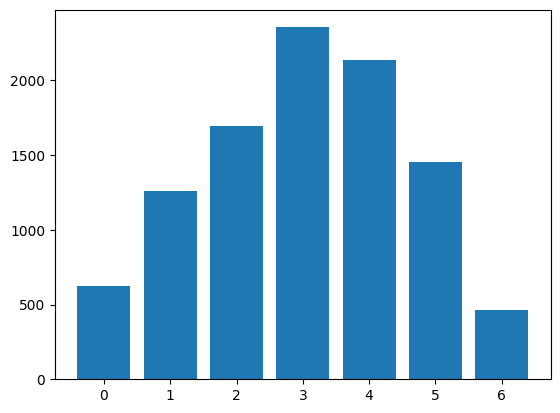

In [16]:
# Plot the chain lengths

import matplotlib.pyplot as plt

plt.bar(chain_lengths.keys(), chain_lengths.values())

<BarContainer object of 14 artists>

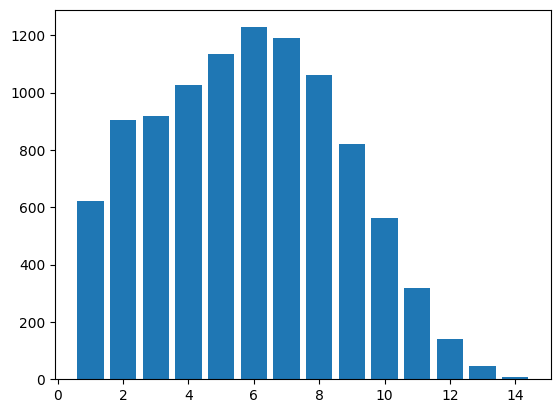

In [18]:
plt.bar(num_rules.keys(), num_rules.values())

In [14]:
# Total number of histories

total_histories = sum(all_history_lengths.values())
print(total_histories)

9180
